<a href="https://colab.research.google.com/github/asvr007/assessment1/blob/master/final_vgg_16_resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

data_dir = '/content/drive/MyDrive/chest_xray'

# Define dataset phases
phases = ['train', 'val', 'test']

# Initialize dictionaries to store counts
normal_counts = {}
pneumonia_counts = {}

# Function to count images in each category
def count_images(root_dir):
    # Initialize count variables
    normal_count = 0
    pneumonia_count = 0

    # List all items in the directory
    for item in os.listdir(root_dir):
        item_path = os.path.join(root_dir, item)
        if os.path.isdir(item_path):
            # If the item is a directory, recurse into it
            if "NORMAL" in item:
                normal_count += len(os.listdir(item_path))
            elif "PNEUMONIA" in item:
                pneumonia_count += len(os.listdir(item_path))
    return normal_count, pneumonia_count

# Iterate over each phase and count images
for phase in phases:
    phase_dir = os.path.join(data_dir, phase)
    normal_count, pneumonia_count = count_images(phase_dir)
    normal_counts[phase] = normal_count
    pneumonia_counts[phase] = pneumonia_count

# Print the counts for each phase
print("Counts in each folder:")
for phase in phases:
    print(f"Folder: {phase}")
    print(f"Normal count: {normal_counts[phase]}")
    print(f"Pneumonia count: {pneumonia_counts[phase]}")
    print()

Counts in each folder:
Folder: train
Normal count: 1341
Pneumonia count: 1313

Folder: val
Normal count: 8
Pneumonia count: 8

Folder: test
Normal count: 241
Pneumonia count: 390



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
----------
train Loss: 0.4435 Acc: 0.7950
val Loss: 0.8001 Acc: 0.7500

Epoch 2/15
----------
train Loss: 0.3094 Acc: 0.8775
val Loss: 0.4670 Acc: 0.6875

Epoch 3/15
----------
train Loss: 0.2699 Acc: 0.8915
val Loss: 0.6354 Acc: 0.6875

Epoch 4/15
----------
train Loss: 0.2673 Acc: 0.8953
val Loss: 0.2887 Acc: 0.8125

Epoch 5/15
----------
train Loss: 0.2595 Acc: 0.8998
val Loss: 0.2202 Acc: 0.9375

Epoch 6/15
----------
train Loss: 0.2194 Acc: 0.9182
val Loss: 0.2897 Acc: 0.8125

Epoch 7/15
----------
train Loss: 0.2201 Acc: 0.9201
val Loss: 0.1217 Acc: 0.9375

Epoch 8/15
----------
train Loss: 0.1762 Acc: 0.9382
val Loss: 0.1502 Acc: 1.0000

Epoch 9/15
----------
train Loss: 0.1717 Acc: 0.9329
val Loss: 0.1731 Acc: 1.0000

Epoch 10/15
----------
train Loss: 0.1698 Acc: 0.9356
val Loss: 0.1884 Acc: 0.8750

Epoch 11/15
----------
train Loss: 0.1633 Acc: 0.9424
val Loss: 0.1633 Acc: 0.9375

Epoch 12/15
----------
train Loss: 0.1563 Acc: 0.9424
val Loss: 0.1357 Acc: 1.0000

E

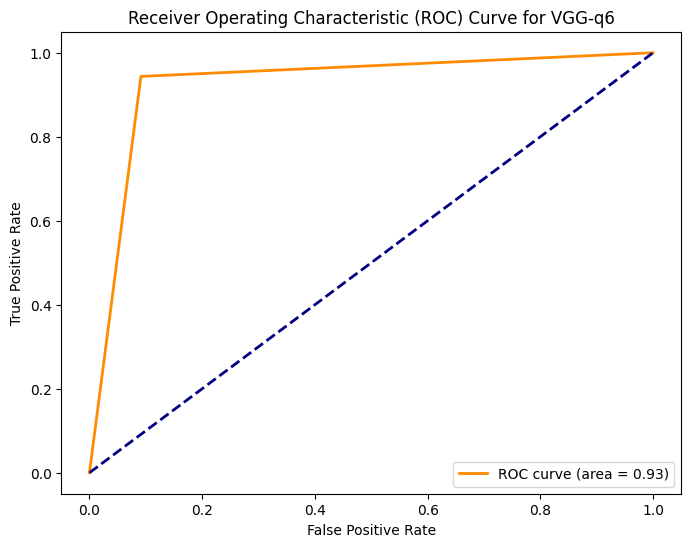

In [ ]:
# vgg version 2

import torch
import os
import copy
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, f1_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data directories
data_dir = '/content/drive/MyDrive/chest_xray'

# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Create image datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

# Create data loaders with reduced num_workers
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=1)  # Reduce batch size and num_workers
    for x in ['train', 'val', 'test']
}

# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Define model
model = models.vgg16(pretrained=True)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)

# Send model to device
model = model.to(device)

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

# Test function
def test_model(model, dataloaders):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Calculate TPR, TNR, FPR, FNR
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    print("True Positive Rate (TPR):", tpr)
    print("True Negative Rate (TNR):", tnr)
    print("False Positive Rate (FPR):", fpr)
    print("False Negative Rate (FNR):", fnr)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    auc = roc_auc_score(true_labels, pred_labels)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC:", auc)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for VGG-q6')
    plt.legend(loc='lower right')
    plt.show()

# Test the model
test_model(model, dataloaders)


In [ ]:
# Saving the model vgg-16 to the drive
# Save the trained VGG-16 model
torch.save(model.state_dict(), '/content/drive/MyDrive/SavedModels/vgg16_model.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
----------
train Loss: 0.2915 Acc: 0.8866
val Loss: 0.2988 Acc: 0.8750

Epoch 2/15
----------
train Loss: 0.2050 Acc: 0.9175
val Loss: 0.4944 Acc: 0.7500

Epoch 3/15
----------
train Loss: 0.1950 Acc: 0.9250
val Loss: 0.6745 Acc: 0.6250

Epoch 4/15
----------
train Loss: 0.1622 Acc: 0.9382
val Loss: 0.5617 Acc: 0.7500

Epoch 5/15
----------
train Loss: 0.1666 Acc: 0.9386
val Loss: 0.1703 Acc: 0.9375

Epoch 6/15
----------
train Loss: 0.1525 Acc: 0.9480
val Loss: 0.1503 Acc: 0.9375

Epoch 7/15
----------
train Loss: 0.1486 Acc: 0.9469
val Loss: 0.1700 Acc: 0.9375

Epoch 8/15
----------
train Loss: 0.1360 Acc: 0.9503
val Loss: 0.2490 Acc: 0.8750

Epoch 9/15
----------
train Loss: 0.1143 Acc: 0.9567
val Loss: 0.2119 Acc: 0.8750

Epoch 10/15
----------
train Loss: 0.1287 Acc: 0.9461
val Loss: 0.2711 Acc: 0.8125

Epoch 11/15
----------
train Loss: 0.1223 Acc: 0.9537
val Loss: 0.4129 Acc: 0.7500

Epoch 12/15
----------
train Loss: 0.1124 Acc: 0.9570
val Loss: 0.0882 Acc: 1.0000

E

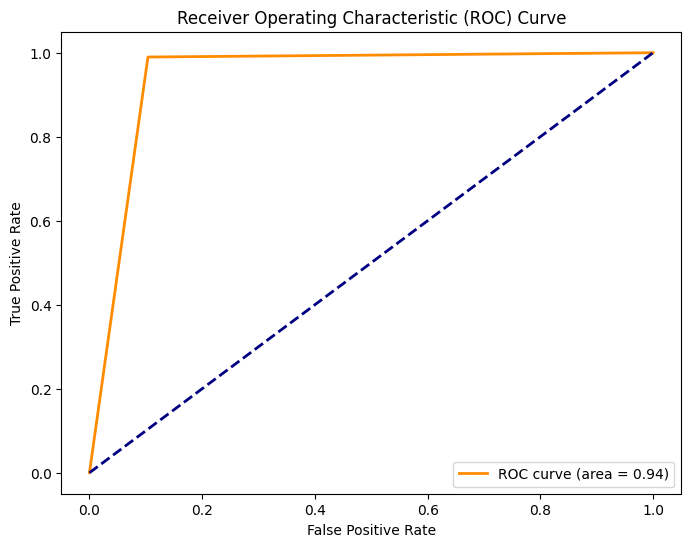

In [7]:
# Resnet-50 version 1
import torch
import os
import copy
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, f1_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data directories
data_dir = '/content/drive/MyDrive/chest_xray'

# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Create image datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

# Create data loaders with reduced num_workers
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['train', 'val', 'test']
}

# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Define model (ResNet-50) with slight modification for regularization
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = True

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 2)
)

model = model.to(device)

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)  # AdamW optimizer

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step(running_loss)  # Adjust learning rate based on train loss

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=1)



# Test function
def test_model(model, dataloaders):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Calculate TPR, TNR, FPR, FNR
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    print("True Positive Rate (TPR):", tpr)
    print("True Negative Rate (TNR):", tnr)
    print("False Positive Rate (FPR):", fpr)
    print("False Negative Rate (FNR):", fnr)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    auc = roc_auc_score(true_labels, pred_labels)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC:", auc)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Test the model
test_model(model, dataloaders)


In [10]:
# Save the trained model resnet-50 to the drivve
torch.save(model.state_dict(), '/content/drive/MyDrive/SavedModels/resnet50_model.pth')
